# Additional Readings
You can read the full description of project here:
https://medium.com/@Markeko/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7

# Import libraries

In [311]:
#Import data packages
import os
import sys
import glob
import numpy as np
import pandas as pd
from google.colab import drive

#Import audio packages
import librosa
import librosa.display
from scipy.io import wavfile
import scipy.io.wavfile
import sys

#Import plotting packages
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import seaborn as sns

#Import Keras & Tensorflow packages
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

## Read CREMA-D Dataset

In [312]:
#Build list of files

# Mount Google Drive
drive.mount('/content/drive')

# Directory path to your dataset
dataset_path = '/content/drive/MyDrive/AudioWAV/'

rawdata_list = os.listdir(dataset_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [313]:
#Review list of files
print(rawdata_list)

['1079_TSI_SAD_XX.wav', '1079_TAI_SAD_XX.wav', '1079_TAI_HAP_XX.wav', '1080_IEO_NEU_XX.wav', '1079_ITH_HAP_XX.wav', '1079_TSI_NEU_XX.wav', '1079_IWW_DIS_XX.wav', '1079_IOM_FEA_XX.wav', '1079_IWL_ANG_XX.wav', '1080_IEO_HAP_LO.wav', '1079_DFA_NEU_XX.wav', '1079_IOM_SAD_XX.wav', '1079_IEO_ANG_HI.wav', '1079_DFA_FEA_XX.wav', '1079_IEO_ANG_MD.wav', '1079_IEO_SAD_LO.wav', '1079_TAI_FEA_XX.wav', '1079_IWW_SAD_XX.wav', '1080_DFA_HAP_XX.wav', '1079_IEO_HAP_MD.wav', '1080_IEO_FEA_HI.wav', '1080_IEO_FEA_MD.wav', '1079_IEO_DIS_MD.wav', '1079_IEO_HAP_LO.wav', '1080_IEO_HAP_MD.wav', '1079_IEO_NEU_XX.wav', '1079_IEO_ANG_LO.wav', '1079_IEO_FEA_HI.wav', '1079_IEO_HAP_HI.wav', '1079_IWW_ANG_XX.wav', '1079_IEO_DIS_HI.wav', '1079_DFA_HAP_XX.wav', '1079_IEO_FEA_MD.wav', '1079_IWW_NEU_XX.wav', '1079_DFA_SAD_XX.wav', '1080_WSI_DIS_XX.wav', '1081_ITS_DIS_XX.wav', '1080_WSI_FEA_XX.wav', '1080_TIE_SAD_XX.wav', '1080_ITH_ANG_XX.wav', '1080_IOM_SAD_XX.wav', '1080_IWL_FEA_XX.wav', '1080_TIE_ANG_XX.wav', '1080_MTI_

## LIbrosa & MFCC configuration
In order to analyze and standardize how each audio file feature was built, the following configurations were determined:

In [314]:
#sample feature
#librosa.core.load(path, sr=22050, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='kaiser_best')
res_type_s = 'kaiser_best'
duration_s = None
sample_rate_s = 22050
offset_s = 0.5

#Mfcc
#librosa.feature.mfcc(y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)
mfcc_sample_rate = 22050
n_mfcc = 40
axis_mfcc = 1

### CREMA-D get emotion features

In [315]:
# Create empty lists for emotions and file paths
file_emotion = []
file_paths = []

# Iterate through all files in the directory
for file_name in os.listdir(dataset_path):
    # Construct the full file path
    file_path_full = os.path.join(dataset_path, file_name)

    # Check if the file is an audio file (assuming WAV format)
    if file_name.lower().endswith('.wav') and os.path.isfile(file_path_full):
        # storing file paths
        file_paths.append(file_path_full)

        # storing file emotions
        part = file_name.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

In [316]:
#Check list
file_emotion

['sad',
 'sad',
 'happy',
 'neutral',
 'happy',
 'neutral',
 'disgust',
 'fear',
 'angry',
 'happy',
 'neutral',
 'sad',
 'angry',
 'fear',
 'angry',
 'sad',
 'fear',
 'sad',
 'happy',
 'happy',
 'fear',
 'fear',
 'disgust',
 'happy',
 'happy',
 'neutral',
 'angry',
 'fear',
 'happy',
 'angry',
 'disgust',
 'happy',
 'fear',
 'neutral',
 'sad',
 'disgust',
 'disgust',
 'fear',
 'sad',
 'angry',
 'sad',
 'fear',
 'angry',
 'disgust',
 'sad',
 'sad',
 'fear',
 'disgust',
 'fear',
 'disgust',
 'sad',
 'angry',
 'sad',
 'disgust',
 'sad',
 'angry',
 'disgust',
 'fear',
 'sad',
 'neutral',
 'neutral',
 'fear',
 'sad',
 'angry',
 'disgust',
 'angry',
 'neutral',
 'fear',
 'sad',
 'sad',
 'neutral',
 'angry',
 'angry',
 'disgust',
 'happy',
 'neutral',
 'neutral',
 'angry',
 'sad',
 'sad',
 'fear',
 'happy',
 'neutral',
 'happy',
 'disgust',
 'sad',
 'happy',
 'neutral',
 'disgust',
 'neutral',
 'angry',
 'disgust',
 'fear',
 'neutral',
 'angry',
 'angry',
 'sad',
 'disgust',
 'happy',
 'sad'

In [317]:
#Turn list into dataframe
labels = pd.DataFrame(file_emotion)

In [318]:
#Check shape
labels.shape

(7442, 1)

In [319]:
#Change index name to "emotion"
labels = labels.rename({0: 'emotion'}, axis=1)

In [320]:
labels.shape

(7442, 1)

In [321]:
#Count the number of files per emotion
labels_total = pd.DataFrame(labels.groupby(['emotion']).size())
labels_total

,0
emotion,
angry,1271
disgust,1271
fear,1271
happy,1271
neutral,1087
sad,1271


### CREMA-D get audio features with librosa library

In [322]:

rawdata_crema = pd.DataFrame(columns=['feature'])
bookmark=0

for y in rawdata_list:
    #Change to kaiser_best & 22050 kHz
    #sr > target sampling rate
    #offset=0.5
    X, sample_rate = librosa.load(dataset_path+y,
                                  #res_type = res_type_s,
                                  duration = duration_s,
                                  sr = sample_rate_s,
                                  offset = offset_s)
    sample_rate = np.array(sample_rate)

    #Get MFCCs from each file
    mfccs = librosa.feature.mfcc(   y=X,
                                    sr = mfcc_sample_rate,
                                    n_mfcc = n_mfcc)

    #Calculate mean of MFCCs
    mfccs_mean = np.mean(    mfccs,
                             axis = axis_mfcc)
    feature = mfccs_mean

    #Add MFCCs feature results to list
    rawdata_crema.loc[bookmark] = [feature]
    bookmark=bookmark+1

In [323]:
#Verity data results
rawdata_crema.shape

(7442, 1)

In [324]:
#Verify that there are no null values
rawdata_crema.isnull().values.any()

False

In [325]:
# See array sample of features
rawdata_crema

,feature
0,"[-401.27618, 116.6272, 0.488627, 65.94333, -15..."
1,"[-440.3175, 136.1579, 17.228376, 53.991688, -1..."
2,"[-336.42752, 130.65514, -8.090641, 32.9309, -2..."
3,"[-423.00467, 143.03592, 17.477335, 53.278305, ..."
4,"[-280.05573, 132.73537, -28.70026, 43.12981, -..."
...,...
7437,"[-377.3721, 113.41995, -11.465237, 56.656616, ..."
7438,"[-328.42282, 110.86818, 2.3822522, 48.353325, ..."
7439,"[-426.97635, 146.13885, 8.116814, 60.140743, -..."
7440,"[-419.2845, 152.66829, 11.293657, 48.45641, -1..."


In [326]:
#Turn array into dataframe
rawdata_crema_final = pd.DataFrame(rawdata_crema['feature'].values.tolist())

In [327]:
#Analyze new dataframe shape
rawdata_crema_final.shape

(7442, 40)

In [328]:
# Check data sample
rawdata_crema_final.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-401.276184,116.627197,0.488627,65.943329,-15.709269,28.724211,-23.616907,20.389486,-10.850456,7.325027,...,-1.203651,-0.731226,3.753485,-0.800356,1.926378,-2.219066,3.967894,-2.532324,0.347069,-2.472679
1,-440.317505,136.157898,17.228376,53.991688,-18.900454,28.544439,-13.570518,17.130178,-9.342173,4.956460,...,4.080382,5.024942,6.884964,1.219177,4.790305,-0.792397,2.715258,-2.859335,0.200691,-2.322479
2,-336.427521,130.655136,-8.090641,32.930901,-21.860420,9.873057,-1.471237,3.231655,-10.445426,7.342979,...,0.563780,-1.886651,3.175589,0.474181,1.796705,2.056330,6.073339,2.293361,1.269413,-0.963245
3,-423.004669,143.035919,17.477335,53.278305,-22.395700,26.474739,-11.077621,15.134370,-14.765269,0.363166,...,1.881677,-0.059180,2.132955,-1.283618,2.189486,-1.657856,3.336865,-2.207319,2.236427,-1.409023
4,-280.055725,132.735367,-28.700260,43.129810,-15.997145,-3.942921,-17.287367,-0.249549,-11.239865,-2.474944,...,3.390780,-0.503597,2.462492,-1.668409,2.592177,3.233631,4.557814,0.679704,-1.949862,0.548606


In [329]:
#Join labels with features
newdf_crema = pd.concat([rawdata_crema_final,labels], axis=1)

In [330]:
#Rename dataframe
newdf_crema = newdf_crema.rename(index=str, columns={"0": "label"})

In [331]:
#Analyze dataframe shape
newdf_crema.shape

(7442, 41)

In [332]:
#Anayze dataframe sample
newdf_crema.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-401.276184,116.627197,0.488627,65.943329,-15.709269,28.724211,-23.616907,20.389486,-10.850456,7.325027,...,-0.731226,3.753485,-0.800356,1.926378,-2.219066,3.967894,-2.532324,0.347069,-2.472679,sad
1,-440.317505,136.157898,17.228376,53.991688,-18.900454,28.544439,-13.570518,17.130178,-9.342173,4.956460,...,5.024942,6.884964,1.219177,4.790305,-0.792397,2.715258,-2.859335,0.200691,-2.322479,sad
2,-336.427521,130.655136,-8.090641,32.930901,-21.860420,9.873057,-1.471237,3.231655,-10.445426,7.342979,...,-1.886651,3.175589,0.474181,1.796705,2.056330,6.073339,2.293361,1.269413,-0.963245,happy
3,-423.004669,143.035919,17.477335,53.278305,-22.395700,26.474739,-11.077621,15.134370,-14.765269,0.363166,...,-0.059180,2.132955,-1.283618,2.189486,-1.657856,3.336865,-2.207319,2.236427,-1.409023,neutral
4,-280.055725,132.735367,-28.700260,43.129810,-15.997145,-3.942921,-17.287367,-0.249549,-11.239865,-2.474944,...,-0.503597,2.462492,-1.668409,2.592177,3.233631,4.557814,0.679704,-1.949862,0.548606,happy


In [333]:
#Datafram drop Nan values
newdf_crema.dropna(inplace=True)

In [334]:
from sklearn.utils import shuffle

#Shuffle dataframe
newdf_crema = shuffle(newdf_crema)
newdf_crema.head(10)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
6995,-366.720154,147.093216,7.919588,48.892773,-27.486717,10.874142,-11.682090,5.085953,-15.324980,9.355643,...,-1.718407,2.655661,-1.516178,1.958451,-4.501713,0.247922,-5.232711,0.907843,2.781512,fear
1091,-375.140015,135.115585,8.037451,50.854717,-11.483770,22.541080,-11.505618,7.528919,-12.323339,2.599129,...,-1.856235,2.606340,-2.237260,1.404061,-2.929383,0.991975,-0.751387,3.036884,0.086762,fear
3394,-402.997986,125.626602,12.680796,58.308350,-10.525530,20.004639,-14.985886,-0.817313,-12.342764,4.091568,...,0.634703,2.936526,-1.425633,-0.376217,-3.683984,3.447459,1.695717,2.556466,-0.045658,fear
1167,-391.226990,146.742188,8.508324,42.064816,-16.477579,19.681984,-9.290890,12.056752,-17.577021,-0.270027,...,0.376807,4.653220,-1.594140,2.958209,-0.555149,2.768434,-0.835538,2.785085,-0.596364,fear
3880,-268.160980,126.480881,-25.489510,38.936665,-27.523718,2.556701,-21.415455,2.384383,-10.923717,1.854283,...,-5.146503,3.398973,2.706839,2.629585,-0.575554,4.485131,4.287498,6.140553,2.035783,fear
7379,-422.164917,141.820618,22.485928,53.735947,-12.033761,20.724178,-12.701413,8.761017,-10.586373,0.230566,...,2.170691,5.616908,-1.147497,2.637893,-0.918152,4.352442,1.769983,4.847924,2.280964,disgust
2577,-375.096252,149.901443,9.864084,46.171902,-11.870157,20.387045,-22.382507,-1.085106,-9.790507,2.924158,...,-0.000411,1.618042,-4.155036,1.486901,-0.896311,4.065566,-0.005858,1.504082,-0.779591,neutral
7176,-277.853638,70.502831,-42.690475,29.688147,-21.592945,14.473875,-13.579127,5.957839,-8.115252,0.381369,...,-0.727720,-0.701099,0.511315,2.262791,-3.096506,3.606411,-2.259233,2.169237,-2.132436,angry
4133,-399.121216,151.557465,0.997997,53.836472,-6.926789,19.268061,-24.164133,1.537617,-17.142910,1.676693,...,-0.573178,2.352218,-2.233238,3.799938,0.428602,1.544644,-3.400642,1.921258,2.285333,neutral
636,-329.778748,118.465561,6.229866,52.096375,-23.395227,20.411728,-21.050219,4.380216,-10.222841,4.231446,...,-3.532561,0.441500,-1.273077,1.250716,-3.086517,4.225639,-6.169254,-0.981318,-2.504736,angry


In [335]:
#Verify that there are no null values
newdf_crema.isnull().values.any()

False

In [336]:
# Check dataframe sample
newdf_crema.head(5)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
6995,-366.720154,147.093216,7.919588,48.892773,-27.486717,10.874142,-11.682090,5.085953,-15.324980,9.355643,...,-1.718407,2.655661,-1.516178,1.958451,-4.501713,0.247922,-5.232711,0.907843,2.781512,fear
1091,-375.140015,135.115585,8.037451,50.854717,-11.483770,22.541080,-11.505618,7.528919,-12.323339,2.599129,...,-1.856235,2.606340,-2.237260,1.404061,-2.929383,0.991975,-0.751387,3.036884,0.086762,fear
3394,-402.997986,125.626602,12.680796,58.308350,-10.525530,20.004639,-14.985886,-0.817313,-12.342764,4.091568,...,0.634703,2.936526,-1.425633,-0.376217,-3.683984,3.447459,1.695717,2.556466,-0.045658,fear
1167,-391.226990,146.742188,8.508324,42.064816,-16.477579,19.681984,-9.290890,12.056752,-17.577021,-0.270027,...,0.376807,4.653220,-1.594140,2.958209,-0.555149,2.768434,-0.835538,2.785085,-0.596364,fear
3880,-268.160980,126.480881,-25.489510,38.936665,-27.523718,2.556701,-21.415455,2.384383,-10.923717,1.854283,...,-5.146503,3.398973,2.706839,2.629585,-0.575554,4.485131,4.287498,6.140553,2.035783,fear


In [337]:
#Analyz shape of dataframe
newdf_crema.shape

(7442, 41)

In [338]:
# see number of emotions
newdf_crema[newdf_crema.columns[-1]].nunique()

6

# Dividing the data into test and train

In [339]:
#Split features from targets
X = newdf_crema.iloc[:,:-1]

#Split targets
y = newdf_crema.iloc[:,-1]

In [340]:
#Get sample of target
y

6995     fear
1091     fear
3394     fear
1167     fear
3880     fear
        ...  
5294    happy
3700    happy
208      fear
1818      sad
3339      sad
Name: emotion, Length: 7442, dtype: object

In [341]:
#Get sample of features
X

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
6995,-366.720154,147.093216,7.919588,48.892773,-27.486717,10.874142,-11.682090,5.085953,-15.324980,9.355643,...,5.017197,-1.718407,2.655661,-1.516178,1.958451,-4.501713,0.247922,-5.232711,0.907843,2.781512
1091,-375.140015,135.115585,8.037451,50.854717,-11.483770,22.541080,-11.505618,7.528919,-12.323339,2.599129,...,-1.481930,-1.856235,2.606340,-2.237260,1.404061,-2.929383,0.991975,-0.751387,3.036884,0.086762
3394,-402.997986,125.626602,12.680796,58.308350,-10.525530,20.004639,-14.985886,-0.817313,-12.342764,4.091568,...,3.124281,0.634703,2.936526,-1.425633,-0.376217,-3.683984,3.447459,1.695717,2.556466,-0.045658
1167,-391.226990,146.742188,8.508324,42.064816,-16.477579,19.681984,-9.290890,12.056752,-17.577021,-0.270027,...,-0.465058,0.376807,4.653220,-1.594140,2.958209,-0.555149,2.768434,-0.835538,2.785085,-0.596364
3880,-268.160980,126.480881,-25.489510,38.936665,-27.523718,2.556701,-21.415455,2.384383,-10.923717,1.854283,...,-4.220907,-5.146503,3.398973,2.706839,2.629585,-0.575554,4.485131,4.287498,6.140553,2.035783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,-365.177216,154.233139,4.992226,35.418434,-7.256603,1.942297,-5.679349,2.311800,-13.206418,1.842241,...,-1.330672,-0.955560,2.798362,-0.672934,3.125833,0.643342,2.637715,1.332783,-0.378993,-1.197848
3700,-340.956848,136.116577,9.458153,40.344784,-21.465359,20.735714,-12.839838,7.756741,-19.842703,-6.344436,...,0.315668,-3.034226,-1.771240,-1.231228,6.773351,3.833033,7.685800,2.632128,3.638430,-0.336697
208,-309.033813,105.437988,-13.220423,49.286789,-23.298084,21.131151,-24.835865,1.643088,-14.682877,6.092548,...,-1.874704,-0.954800,-1.296907,-5.416854,-0.163969,-2.794113,4.947879,-3.800856,1.426388,-1.938744
1818,-422.361755,140.972031,10.780872,60.183079,1.442786,22.985250,-23.310900,0.349593,-8.528319,5.096893,...,-0.176209,-0.209516,2.871639,-4.686393,0.489442,1.175918,5.347087,-0.937950,0.013606,-1.883324


In [342]:
from sklearn.model_selection import train_test_split

#Split train & test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=1)

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (6697, 40)
y_train shape: (6697,)
X_test shape: (745, 40)
y_test shape: (745,)


In [343]:
#Check unique values for y_test
y_test.unique()

array(['disgust', 'happy', 'fear', 'angry', 'neutral', 'sad'],
      dtype=object)

In [344]:
#Check unique values for y_train
y_train.unique()

array(['angry', 'neutral', 'fear', 'sad', 'happy', 'disgust'],
      dtype=object)

In [345]:
#Label Encoding
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

#Encode emotion labels into numbers
y_train_lb = to_categorical(lb.fit_transform(y_train))
y_test_lb = to_categorical(lb.fit_transform(y_test))

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train_lb.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test_lb.shape}')

X_train shape: (6697, 40)
y_train shape: (6697, 6)
X_test shape: (745, 40)
y_test shape: (745, 6)


In [346]:
#Check encoding
np.unique(y_train_lb, axis=0)

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [347]:
# range of x values
print(f'X range: {X_train.min()}-{X_train.max()}')
# y unique values
print(f'y values: {np.unique(y_train_lb)}')
num_classes = len(np.unique(y_train_lb))
print(f'Number of classes: {num_classes}')

X range: 0    -1131.370972
1        0.000000
2      -68.648987
3        0.000000
4      -62.631050
5      -25.226511
6      -42.655819
7      -15.034383
8      -36.962639
9      -14.159490
10     -16.950233
11     -21.176552
12     -13.157246
13     -20.773066
14     -11.182359
15     -32.811798
16     -14.977752
17     -23.285896
18     -13.050726
19     -19.889174
20     -16.816935
21     -16.036276
22     -15.386578
23      -9.244330
24     -13.768228
25      -5.063877
26     -12.872783
27      -7.368146
28      -9.844578
29      -8.949030
30      -9.352779
31     -11.936197
32      -7.366941
33     -10.518729
34      -7.454337
35     -11.204182
36      -5.823586
37      -9.298221
38      -6.747974
39      -6.542993
dtype: float32-0     -97.526924
1     170.880249
2      34.916832
3      87.653427
4      17.578310
5      67.757523
6       9.354650
7      33.372646
8       0.000000
9      19.608679
10     27.741688
11     18.555361
12     29.545090
13     14.499503
14     24.282417
1

## Build list of labels to build confusion matrix after model

In [348]:
#Check encoding labels
lb.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [349]:
#Build new lists of encoding labels
y_labels_encoded = {}
for i, label in enumerate(lb.classes_):
    y_labels_encoded[i] = label

y_labels_encoded

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad'}

# Scale data for analysis

In [350]:
from sklearn.preprocessing import StandardScaler
#Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scalled = scaler.transform(X_train)
X_test_scalled = scaler.transform(X_test)

# Build model - Convolution Neural Network

### Change dimensions for CNN model

In [351]:
#Add dimension for CNN
x_traincnn = np.expand_dims(X_train_scalled, axis=2)
x_testcnn = np.expand_dims(X_test_scalled, axis=2)

#Check shapes of dataframes
print(x_traincnn.shape)
print(x_testcnn.shape)

(6697, 40, 1)
(745, 40, 1)


In [352]:
#Import packages for CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten, MaxPooling2D

In [353]:
#Build sequential CNN
CNN_model = Sequential()

#Build first layer
CNN_model.add(Conv1D(32, 5,padding='same',
                 input_shape=(40, 1), activation='relu'))

#Build second layer
CNN_model.add(Conv1D(32, 5,padding='same',activation='relu'))

#Build third layer
CNN_model.add(Conv1D(64, 5,padding='same',activation='relu'))

#Build forth layer
CNN_model.add(Conv1D(128, 5,padding='same',activation='relu'))

#Add dropout
#CNN_model.add(Dropout(0.1))

#Flatten
CNN_model.add(Flatten())

CNN_model.add(Dense(128, activation ='relu'))
#CNN_model.add(Dropout(0.1))
CNN_model.add(Dense(64, activation ='relu'))
CNN_model.add(Dense(6, activation='softmax'))

In [354]:
#Look at CNN model summary
CNN_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 40, 32)            192       
                                                                 
 conv1d_29 (Conv1D)          (None, 40, 32)            5152      
                                                                 
 conv1d_30 (Conv1D)          (None, 40, 64)            10304     
                                                                 
 conv1d_31 (Conv1D)          (None, 40, 128)           41088     
                                                                 
 flatten_7 (Flatten)         (None, 5120)              0         
                                                                 
 dense_21 (Dense)            (None, 128)               655488    
                                                                 
 dense_22 (Dense)            (None, 64)               

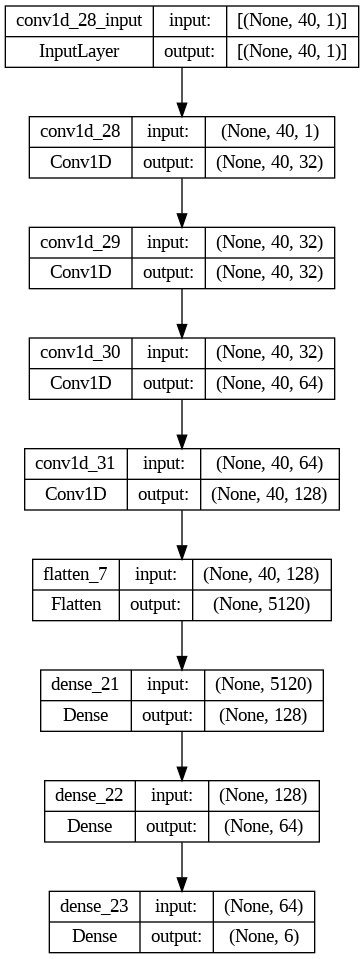

In [355]:
from keras.utils import plot_model

# Save an image of the model's architecture to a file
plot_model(CNN_model, to_file='Feed Forward NN.png', show_shapes=True, show_layer_names=True)

In [356]:
# Compile the model with the desired loss function, optimizer, and metric to optimize
CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [357]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5',
                               verbose=1, save_best_only=True)

#Model fit
cnn_results = CNN_model.fit(x_traincnn, y_train_lb,
              batch_size = 16,
              epochs = 50,
              verbose = 1,
              validation_data = (x_testcnn, y_test_lb))

Epoch 1/50
419/419 [==============================] - 8s 17ms/step - loss: 1.4848 - accuracy: 0.3875 - val_loss: 1.4276 - val_accuracy: 0.3839
Epoch 2/50
419/419 [==============================] - 9s 22ms/step - loss: 1.3395 - accuracy: 0.4596 - val_loss: 1.3537 - val_accuracy: 0.4631
Epoch 3/50
419/419 [==============================] - 7s 16ms/step - loss: 1.2518 - accuracy: 0.4913 - val_loss: 1.2997 - val_accuracy: 0.4805
Epoch 4/50
419/419 [==============================] - 9s 22ms/step - loss: 1.1425 - accuracy: 0.5537 - val_loss: 1.3254 - val_accuracy: 0.4899
Epoch 5/50
419/419 [==============================] - 7s 16ms/step - loss: 1.0068 - accuracy: 0.6037 - val_loss: 1.3492 - val_accuracy: 0.4698
Epoch 6/50
419/419 [==============================] - 9s 22ms/step - loss: 0.8421 - accuracy: 0.6752 - val_loss: 1.4826 - val_accuracy: 0.4779
Epoch 7/50
419/419 [==============================] - 7s 16ms/step - loss: 0.6391 - accuracy: 0.7591 - val_loss: 1.6992 - val_accuracy: 0.4819

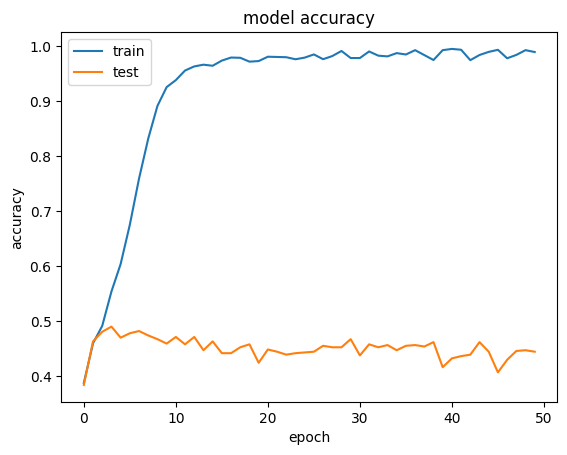

In [358]:
#Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

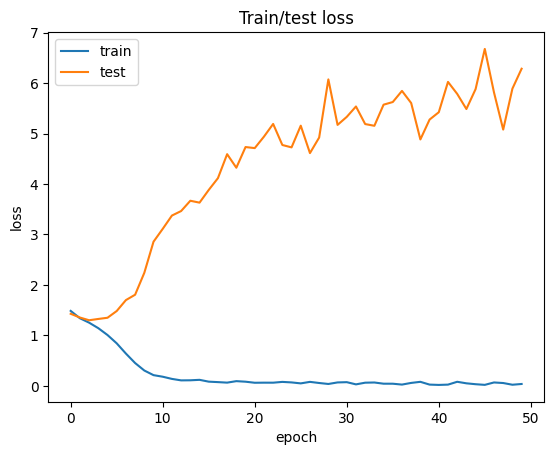

In [383]:
#Plot model accuracy over ephocs
plt.plot(cnn_results.history['loss'])
plt.plot(cnn_results.history['val_loss'])
plt.title('Train/test loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [359]:
# Calculate pre-training accuracy
score = CNN_model.evaluate(x_testcnn, y_test_lb, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

24/24 [==============================] - 0s 11ms/step - loss: 6.2843 - accuracy: 0.4443
Pre-training accuracy: 44.4295%


In [360]:
# Evaluating the model on the training and testing set
score = CNN_model.evaluate(x_traincnn, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1])

score = CNN_model.evaluate(x_testcnn, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9904434680938721
Testing Accuracy:  0.4442952871322632


# Add Confusion Matrix

In [361]:
#Get predictions from model
y_test_predictions_inter = CNN_model.predict(x_testcnn)
y_test_predictions=np.argmax(y_test_predictions_inter,axis=1)
y_test_predictions

24/24 [==============================] - 0s 7ms/step


array([5, 1, 2, 1, 4, 3, 0, 0, 0, 0, 1, 3, 1, 0, 4, 5, 0, 4, 0, 0, 1, 4,
       5, 4, 5, 5, 4, 1, 4, 4, 1, 3, 2, 1, 4, 0, 1, 5, 3, 5, 0, 4, 5, 2,
       5, 5, 2, 0, 1, 2, 5, 4, 5, 0, 4, 0, 4, 3, 1, 3, 5, 1, 2, 1, 5, 0,
       5, 1, 3, 0, 4, 3, 2, 5, 3, 1, 1, 3, 4, 3, 4, 5, 0, 4, 4, 5, 0, 1,
       3, 1, 1, 5, 3, 5, 4, 0, 0, 5, 0, 5, 4, 1, 5, 1, 5, 1, 4, 4, 4, 5,
       1, 3, 5, 0, 4, 0, 3, 4, 1, 0, 1, 4, 5, 5, 0, 4, 5, 4, 4, 5, 2, 0,
       5, 1, 4, 3, 5, 5, 1, 4, 4, 5, 0, 2, 4, 5, 2, 0, 2, 0, 5, 5, 3, 3,
       4, 0, 3, 3, 2, 3, 5, 5, 3, 0, 2, 1, 5, 2, 5, 5, 3, 5, 0, 1, 2, 4,
       5, 5, 1, 4, 4, 4, 3, 5, 3, 4, 5, 0, 0, 1, 5, 1, 0, 5, 0, 1, 5, 4,
       1, 5, 5, 3, 0, 4, 3, 1, 5, 3, 0, 0, 4, 1, 2, 4, 3, 0, 5, 4, 4, 1,
       2, 1, 3, 5, 5, 0, 0, 3, 4, 3, 4, 0, 3, 1, 2, 5, 5, 2, 2, 4, 4, 0,
       1, 1, 1, 1, 0, 5, 1, 5, 3, 1, 4, 3, 4, 4, 3, 5, 1, 2, 0, 5, 2, 3,
       0, 1, 5, 3, 3, 4, 2, 4, 3, 1, 4, 3, 0, 1, 3, 3, 0, 0, 1, 2, 2, 0,
       1, 2, 4, 5, 3, 2, 0, 5, 0, 0, 4, 2, 0, 4, 1,

In [362]:
y_test

968     disgust
1380      happy
4613       fear
3322      happy
6637    disgust
         ...   
1810       fear
1360       fear
3939      angry
4375    neutral
241     disgust
Name: emotion, Length: 745, dtype: object

In [363]:
#Get labels for emotions
y_labels_encoded

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad'}

In [365]:
# Change predictions to emotions in order to compare
y_test_predictions_labels =[]

#Go through each prediction and append to new list
for e in range(len(y_test_predictions)):
    y_test_predictions_labels.append(y_labels_encoded[y_test_predictions[e]])

#Build array of predictions
y_test_predictions_labels = np.array(y_test_predictions_labels)
y_test_predictions_labels

array(['sad', 'disgust', 'fear', 'disgust', 'neutral', 'happy', 'angry',
       'angry', 'angry', 'angry', 'disgust', 'happy', 'disgust', 'angry',
       'neutral', 'sad', 'angry', 'neutral', 'angry', 'angry', 'disgust',
       'neutral', 'sad', 'neutral', 'sad', 'sad', 'neutral', 'disgust',
       'neutral', 'neutral', 'disgust', 'happy', 'fear', 'disgust',
       'neutral', 'angry', 'disgust', 'sad', 'happy', 'sad', 'angry',
       'neutral', 'sad', 'fear', 'sad', 'sad', 'fear', 'angry', 'disgust',
       'fear', 'sad', 'neutral', 'sad', 'angry', 'neutral', 'angry',
       'neutral', 'happy', 'disgust', 'happy', 'sad', 'disgust', 'fear',
       'disgust', 'sad', 'angry', 'sad', 'disgust', 'happy', 'angry',
       'neutral', 'happy', 'fear', 'sad', 'happy', 'disgust', 'disgust',
       'happy', 'neutral', 'happy', 'neutral', 'sad', 'angry', 'neutral',
       'neutral', 'sad', 'angry', 'disgust', 'happy', 'disgust',
       'disgust', 'sad', 'happy', 'sad', 'neutral', 'angry', 'angry',


In [374]:
from sklearn.metrics import confusion_matrix

#Build confusion matrix and see results
confusion_matrix = confusion_matrix(y_test, y_test_predictions_labels)
confusion_matrix

array([[96, 12,  7, 23,  6,  1],
       [ 9, 40, 10, 18, 18, 22],
       [ 9, 19, 37, 20, 18, 25],
       [21, 22, 13, 50, 16,  7],
       [ 2, 13,  3, 16, 47, 22],
       [ 1, 13, 18,  4, 26, 61]])

In [375]:
#See confusion matrix shape
confusion_matrix.shape

(6, 6)

In [376]:
#Turn al correct answers into 0 to visualize errors better
#for i in range(confusion_matrix.shape[0]):
#    for j in range(confusion_matrix.shape[1]):
#        if i == j:
#            confusion_matrix[i,j] = 0

# See results
#confusion_matrix

In [377]:
#Add labels to confusion matrix
confusion_matrix = pd.DataFrame(confusion_matrix, columns=list(y_labels_encoded.values()), index=list(y_labels_encoded.values()))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix

The rows represents the true values or observations
The columns respresent the model's predictions


,angry,disgust,fear,happy,neutral,sad
angry,96,12,7,23,6,1
disgust,9,40,10,18,18,22
fear,9,19,37,20,18,25
happy,21,22,13,50,16,7
neutral,2,13,3,16,47,22
sad,1,13,18,4,26,61


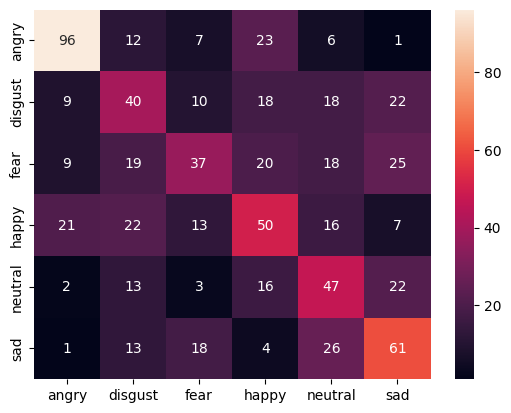

In [378]:
#Plot confusion matrix with results
ax = sns.heatmap(confusion_matrix, annot=True)

# Save CNN Model

In [379]:
from keras.models import model_from_json
# serialize model to json
json_model = CNN_model.to_json()
#save the model architecture to JSON file
with open('capstone_project_emotion_detection_final_version.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
CNN_model.save_weights('capstone_project_emotion_detection_final_version.h5')
#Model loss and accuracy
print("Saved model to disk")

Saved model to disk


In [380]:
# load json and create model
json_file = open('capstone_project_emotion_detection_final_version.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("capstone_project_emotion_detection_final_version.h5")
print("Loaded model from disk")

Loaded model from disk


In [381]:
from keras.initializers import glorot_uniform
#Reading the model from JSON file
with open('capstone_project_emotion_detection_final_version.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture
model_load = keras.models.model_from_json(json_savedModel)
model_load.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 40, 32)            192       
                                                                 
 conv1d_29 (Conv1D)          (None, 40, 32)            5152      
                                                                 
 conv1d_30 (Conv1D)          (None, 40, 64)            10304     
                                                                 
 conv1d_31 (Conv1D)          (None, 40, 128)           41088     
                                                                 
 flatten_7 (Flatten)         (None, 5120)              0         
                                                                 
 dense_21 (Dense)            (None, 128)               655488    
                                                                 
 dense_22 (Dense)            (None, 64)               